# 1. Prepare unput data for gen_train_data()

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm#
from bs4 import BeautifulSoup
import sys
import os
import time
from pathlib import Path
import ast
from datetime import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
current_path = os.getcwd()
current_path

'/home/tuhin1994/Tuhin/Machine learning code/ML new/long-term-social-networks-develop/notebooks'

In [3]:
ml_action_temp_folder = Path("../processed/actions_day_1.csv")
df = pd.read_csv(ml_action_temp_folder)
df.head()

,Unnamed: 0,person,time,container,end_time,groupSize,contactPeople,almostContactPeople
0,0,21,122385.0,sec_490124,124837.0,[1],[],NaN
1,1,21,125232.0,sec_425380,126637.0,[1],[],NaN
2,2,21,127214.0,home_5,139237.0,[1],[],NaN
3,3,21,139380.0,PT!100110007:7!120200199-1_202458!120062097-1_...,139860.0,[2],[9437416],NaN
4,4,21,140160.0,PT!100100180:180!120178341-1_235191!120178340-...,141059.0,[1],[],NaN


In [4]:
data = []
for row_num, row in df.iterrows():
    data.append({
        "id": row["person"],
        "datetime": row["time"],
        "concept": row["container"],
        "duration": int(row["end_time"]) - int(row["time"]),
        "groupSize": max(ast.literal_eval(row["groupSize"])),
        "contact": (len(ast.literal_eval(row["contactPeople"])) != 0)
    })
    
action_df = pd.DataFrame(data, columns=["id", "datetime", "concept", "duration", "groupSize", "contact"])
# action_df.to_csv(save_to / f"actions_{1}.csv", index=False)


In [5]:
df=action_df.copy()
action_df.head()



,id,datetime,concept,duration,groupSize,contact
0,21,122385.0,sec_490124,2452,1,False
1,21,125232.0,sec_425380,1405,1,False
2,21,127214.0,home_5,12023,1,False
3,21,139380.0,PT!100110007:7!120200199-1_202458!120062097-1_...,480,2,True
4,21,140160.0,PT!100100180:180!120178341-1_235191!120178340-...,899,1,False


In [7]:
def convert_to_dt(timestamp):
    return time.strftime("%Y-%m-%d %H-%M-%S", time.gmtime(timestamp))


tqdm.pandas()

df["datetime"] = df["datetime"].progress_apply(convert_to_dt)

100%|██████████| 558860/558860 [00:01<00:00, 510292.31it/s]


In [8]:
df.head()

,id,datetime,concept,duration,groupSize,contact
0,21,1970-01-02 09-59-45,sec_490124,2452,1,False
1,21,1970-01-02 10-47-12,sec_425380,1405,1,False
2,21,1970-01-02 11-20-14,home_5,12023,1,False
3,21,1970-01-02 14-43-00,PT!100110007:7!120200199-1_202458!120062097-1_...,480,2,True
4,21,1970-01-02 14-56-00,PT!100100180:180!120178341-1_235191!120178340-...,899,1,False


In [4]:
df.to_csv("../actions_1.csv")

NameError: name 'df' is not defined

# 2. Prepare final train_concept file for learn_embeddings()

In [4]:
path = "../ml_action_temp_folder/train_concept.csv"

In [5]:
df = pd.read_csv(path)
df

,1086.0,1087.0,2973.0,28292.0,4.0
0,1087.0,1086.0,2973.0,28292.0,4.0
1,1086.0,1088.0,34380.0,0.0,1.0
2,1088.0,1086.0,34380.0,0.0,1.0
3,1087.0,1088.0,31407.0,28292.0,3.0
4,1088.0,1087.0,31407.0,28292.0,3.0
...,...,...,...,...,...
1904966,15107.0,47634.0,2085.0,21.0,2.0
1904967,47634.0,11918.0,4485.0,819.0,1.0
1904968,11918.0,47634.0,4485.0,819.0,1.0
1904969,15107.0,11918.0,2400.0,840.0,1.0


In [6]:
df.columns =['input', 'target', 'time_difference', 'duration_difference','group_size_difference']

In [7]:
df

,input,target,time_difference,duration_difference,group_size_difference
0,1087.0,1086.0,2973.0,28292.0,4.0
1,1086.0,1088.0,34380.0,0.0,1.0
2,1088.0,1086.0,34380.0,0.0,1.0
3,1087.0,1088.0,31407.0,28292.0,3.0
4,1088.0,1087.0,31407.0,28292.0,3.0
...,...,...,...,...,...
1904966,15107.0,47634.0,2085.0,21.0,2.0
1904967,47634.0,11918.0,4485.0,819.0,1.0
1904968,11918.0,47634.0,4485.0,819.0,1.0
1904969,15107.0,11918.0,2400.0,840.0,1.0


In [8]:
def exponential_decay(const, rate, x):
    return const * np.e**(-rate*x)

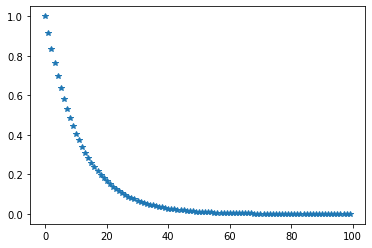

In [9]:
plt.plot(list(range(100)), [exponential_decay(1, 0.09, x) for x in range(100)], '*')
plt.show()

In [10]:
time_const = 1
time_rate = 0.0009

def transform_time(time):
    return exponential_decay(time_const, time_rate, time)

In [11]:
tqdm.pandas()
df["time_difference"] = df["time_difference"].progress_apply(transform_time)

100%|██████████| 1904971/1904971 [00:02<00:00, 931188.93it/s] 


In [12]:
values = list(df["time_difference"])

In [13]:
from collections import Counter

In [14]:
cnt = Counter(values)

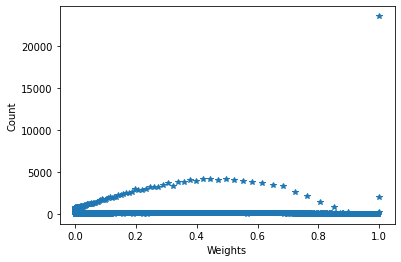

In [15]:
plt.plot(list(cnt.keys()), list(cnt.values()), "*")
plt.xlabel("Weights")
plt.ylabel("Count")
plt.savefig("./gs_weights.jpg")
plt.show()

In [16]:
df["duration_difference"] = df["duration_difference"].progress_apply(transform_time)

100%|██████████| 1904971/1904971 [00:02<00:00, 925008.63it/s] 


In [17]:
values = list(df["duration_difference"])
cnt = Counter(values)

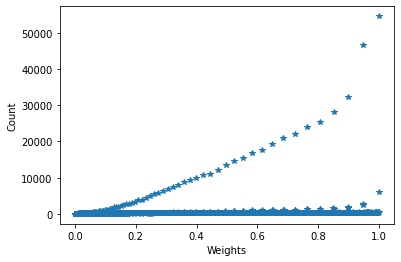

In [18]:
plt.plot(list(cnt.keys()), list(cnt.values()), "*")
plt.xlabel("Weights")
plt.ylabel("Count")
plt.savefig("./dd_weights.jpg")
plt.show()

In [19]:
time_const = 1
time_rate = 0.09

def transform_group(time):
    return exponential_decay(time_const, time_rate, time)

df["group_size_difference"] = df["group_size_difference"].progress_apply(transform_group)

100%|██████████| 1904971/1904971 [00:01<00:00, 962204.11it/s] 


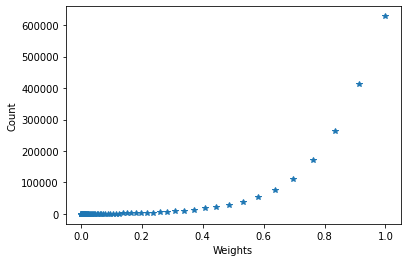

In [20]:
values = list(df["group_size_difference"])
cnt = Counter(values)
plt.plot(list(cnt.keys()), list(cnt.values()), "*")
plt.xlabel("Weights")
plt.ylabel("Count")
plt.savefig("./gs_weights.jpg")
plt.show()

In [21]:
df["weight"] = (df["time_difference"] + df["duration_difference"] + df["group_size_difference"]) / 3
df

,input,target,time_difference,duration_difference,group_size_difference,weight
0,1087.0,1086.0,6.885861e-02,8.742718e-12,0.697676,0.255512
1,1086.0,1088.0,3.648045e-14,1.000000e+00,0.913931,0.637977
2,1088.0,1086.0,3.648045e-14,1.000000e+00,0.913931,0.637977
3,1087.0,1088.0,5.297877e-13,8.742718e-12,0.763379,0.254460
4,1088.0,1087.0,5.297877e-13,8.742718e-12,0.763379,0.254460
...,...,...,...,...,...,...
1904966,15107.0,47634.0,1.531251e-01,9.812775e-01,0.835270,0.656558
1904967,47634.0,11918.0,1.765917e-02,4.784996e-01,0.913931,0.470030
1904968,11918.0,47634.0,1.765917e-02,4.784996e-01,0.913931,0.470030
1904969,15107.0,11918.0,1.153251e-01,4.695408e-01,0.913931,0.499599


In [22]:
df1 = df.copy(deep=True)
df1 = df1.drop(["time_difference", "duration_difference", "group_size_difference"], axis=1)
df1

,input,target,weight
0,1087.0,1086.0,0.255512
1,1086.0,1088.0,0.637977
2,1088.0,1086.0,0.637977
3,1087.0,1088.0,0.254460
4,1088.0,1087.0,0.254460
...,...,...,...
1904966,15107.0,47634.0,0.656558
1904967,47634.0,11918.0,0.470030
1904968,11918.0,47634.0,0.470030
1904969,15107.0,11918.0,0.499599


In [23]:
data = df1.to_numpy()
final_df = pd.DataFrame(data)

In [24]:
final_df[0] = final_df[0].astype(int)
final_df[1] = final_df[1].astype(int)
final_df

,0,1,2
0,1087,1086,0.255512
1,1086,1088,0.637977
2,1088,1086,0.637977
3,1087,1088,0.254460
4,1088,1087,0.254460
...,...,...,...
1904966,15107,47634,0.656558
1904967,47634,11918,0.470030
1904968,11918,47634,0.470030
1904969,15107,11918,0.499599


In [32]:
final_df.columns =['input', 'target', 'weight']
train_file = open("../embedding_data/train_concept_final.csv", 'w')
final_df.to_csv(train_file, header=False, index=False)
train_file.close()

# Cluster analysis

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pathlib import Path
import pickle as pkl

In [3]:
embeddings_path = Path("../embedding_data/embedding_v2/embeddings.pkl")
# embeddings_path = Path("../ml_action_temp_folder/embeddings.pkl")

In [4]:
with embeddings_path.open("rb") as handle:
    d = pkl.load(handle)

In [5]:
embeddings = d["final_embeddings"]
len(embeddings)

68634

In [6]:
pca = PCA(n_components=2)
data = pca.fit_transform(embeddings)

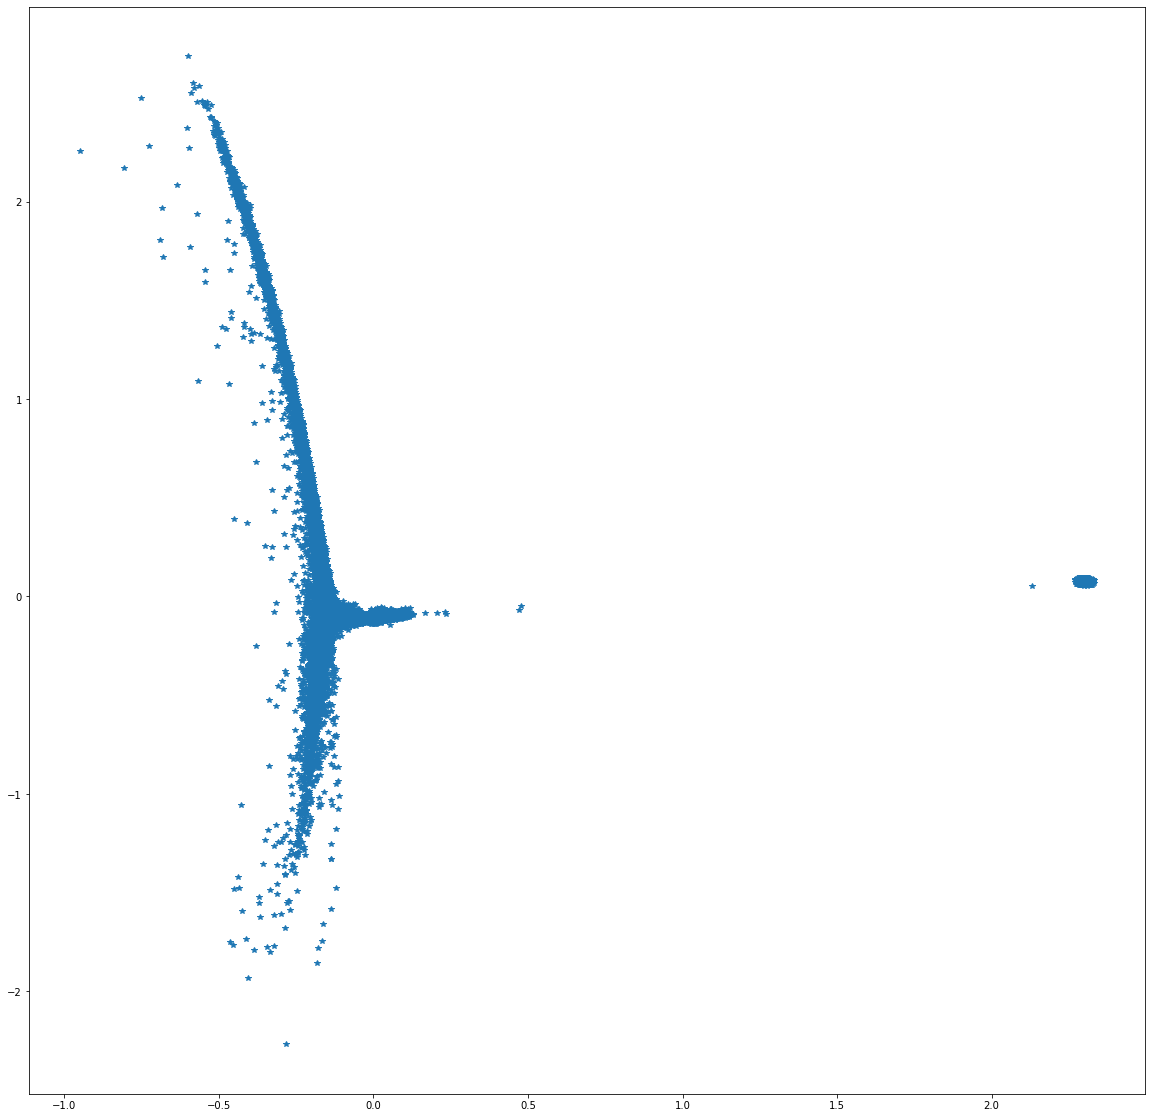

In [7]:
plt.figure(figsize=(20, 20))
plt.plot(data[:, 0], data[:, 1], '*')
plt.savefig("./pca_clusters.jpg")
plt.show()


In [8]:
tsne = TSNE(n_components=2, n_jobs=4)
data_tsne = tsne.fit_transform(embeddings)

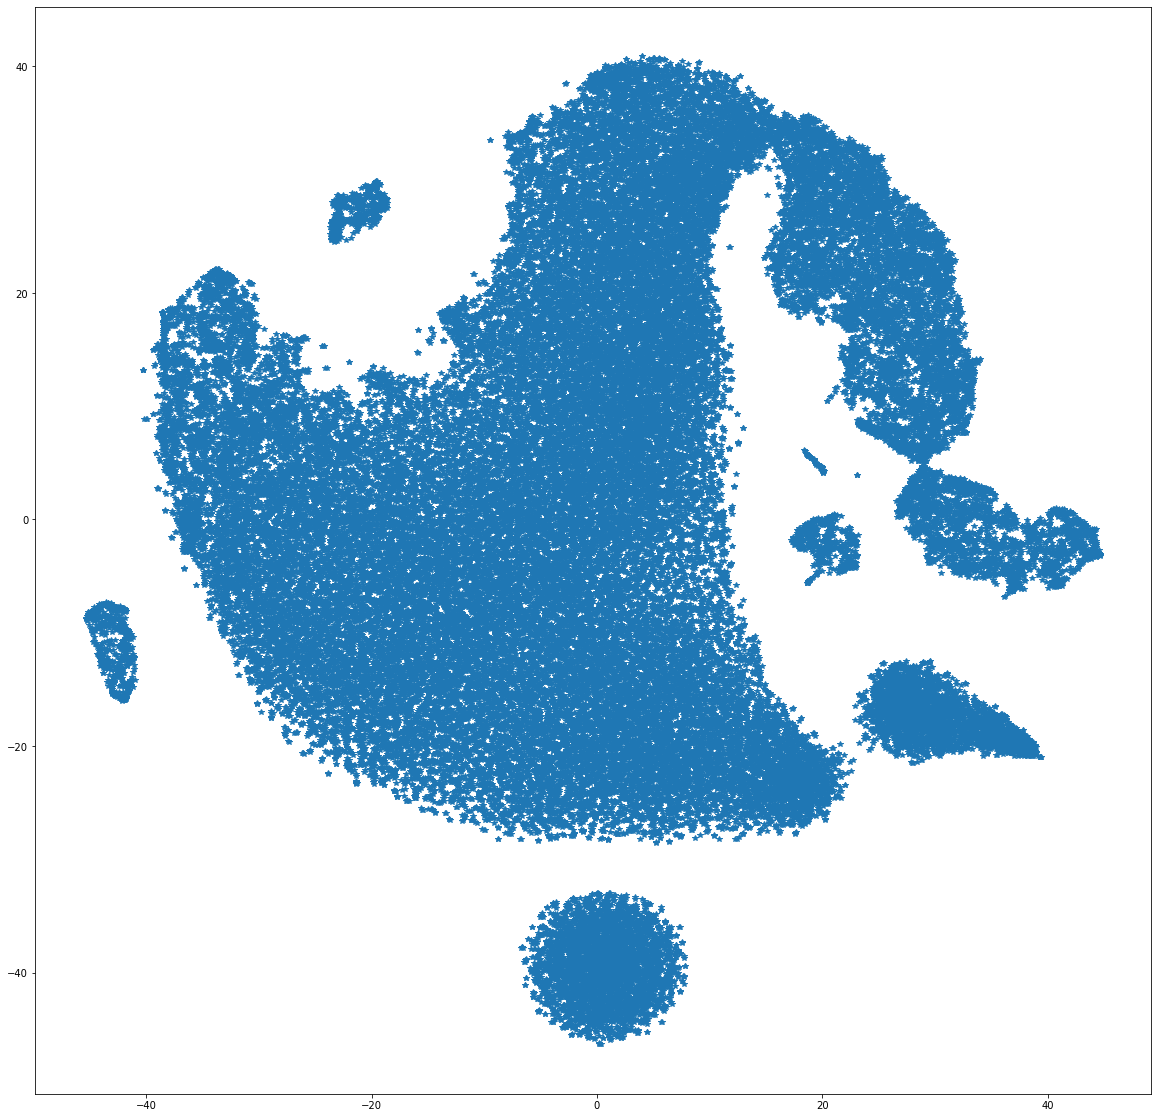

In [9]:
plt.figure(figsize=(20, 20))
plt.plot(data_tsne[:, 0], data_tsne[:, 1], '*')
plt.show()